<table align="left">
<tr>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github//SuperOdins/MachineLearningPractice/blob/main/01.Recommendation_ContentsBased.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</tr>
<tr>
  <td>
    <a href="https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?resource=download" style="font-weight:bold;"> 데이터소스 다운로드(Kaggle)</a>
    <br>
  </td>
      
</tr>
<tr>
  <td>
  데이터는 아래 링크입니다.
  <br>
  Kaggle - https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?resource=download
  <br>

  </td>
</tr>
</table>

패키지 임포트

콘텐츠 기반 추천 알고리즘을 이용해서 추천 시스템을 구현
1. Content-Based Filtering의 정의
- Content-Based Filtering은 아이템 자체의 특성에 초점을 맞춘 추천 방식입니다.
- 각 아이템의 메타데이터(줄거리, 장르, 출연진, 감독 등)를 활용하여 사용자가 선호할 만한 유사한 아이템을 추천합니다.
- 예를 들어, 한 사용자가 특정 영화의 줄거리를 좋아했다면 비슷한 주제나 키워드를 가진 다른 영화를 추천합니다.


In [27]:
#필요한 패키지가 있다면, 아래 줄 주석을 풀고 설치하시면 됩니다. 
# !pip3 install <패키지이름1> <패키지이름2> - - - <패키지이름N>
# !pip3 install scikit-learn


In [43]:
import pandas as pd 
import numpy as np
import os
import matplotlib as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import json

#### `tmdb_5000_movies.csv`의 컬럼

| No. | 컬럼명                 | 설명                                                   |
|-----|------------------------|--------------------------------------------------------|
| 1   | budget                 | 영화의 제작 예산                                        |
| 2   | genres                 | 영화의 장르 (예: 액션, 드라마)                         |
| 3   | homepage               | 영화의 공식 홈페이지 URL                                |
| 4   | id                     | 영화의 고유 ID                                          |
| 5   | keywords               | 영화와 관련된 키워드                                    |
| 6   | original_language      | 영화의 원어 (예: en, ko 등)                             |
| 7   | original_title         | 영화의 원제(Original Title)                             |
| 8   | overview               | 영화의 줄거리 요약                                      |
| 9   | popularity             | 영화의 인기도 (점수로 표현)                             |
| 10  | production_companies   | 영화 제작사 정보                                        |
| 11  | production_countries   | 제작된 국가 정보                                        |
| 12  | release_date           | 영화의 개봉일                                           |
| 13  | revenue                | 영화의 총 수익                                          |
| 14  | runtime                | 영화의 상영 시간(분 단위)                                |
| 15  | spoken_languages       | 영화에서 사용된 언어                                    |
| 16  | status                 | 영화의 상태 (예: Released, Post Production 등)           |
| 17  | tagline                | 영화의 홍보 문구                                        |
| 18  | title                  | 영화의 제목                                             |
| 19  | vote_average           | 관객 평점 평균                                          |
| 20  | vote_count             | 평점 참여자 수                                          |

#### `tmdb_5000_credits.csv`의 컬럼

| No. | 컬럼명   | 설명                                  |
|-----|----------|---------------------------------------|
| 1   | movie_id | 영화의 고유 ID (다른 파일과의 매칭용) |
| 2   | title    | 영화의 제목                           |
| 3   | cast     | 영화 출연진 정보                      |
| 4   | crew     | 영화 제작진 정보 (감독, 작가 등)      |

## 1.데이터 읽기

In [115]:
#로컬시스템에서 돌리거나, 각기 다른 시스템에서 테스트한다면 이렇게 바꾸시는게 정신건강에 이롭습니다. 
movieDataTarget =os.path.join(os.path.abspath(os.getcwd()),'tmdb_5000_movies.csv') 
#같은 디렉토리라면 이렇게 써도 무관하지만.... 
creditDataTarget = "./tmdb_5000_credits.csv" 

movieData = pd.read_csv(movieDataTarget)
creditData = pd.read_csv(creditDataTarget)


정상적으로 임포트 되었는지 상위 5개 출력

In [10]:
movieData.head(5)


budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466  
3                     The Dark Knight Rises           7.6        9106  
4                               John Carter           6.1        2124

In [11]:
creditData.head(5)

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

데이터 갯수 같은지 비교해봅니다. 

In [12]:
print("Shape of movies dataset =", movieData.shape)
print("Shape of credits dataset =", creditData.shape)

Shape of movies dataset = (4803, 20)
Shape of credits dataset = (4803, 4)


# 2. 공식
IMDB의 공식(formula)은 아래와 같음

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

R = average for the movie (mean) = (rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top Rated 250 list (currently 25,000)

C = the mean vote across the whole report

In [13]:
m = movieData['vote_count'].quantile(0.90) #top250에 들어가기 위해서는 상위 90%(표준분포)에 해당하는 값만 해당됨, 쉽게 상위 10% 애들만 구하겠단 소리임.
C = movieData['vote_average'].mean()

In [15]:
#movie에 대한 웨이트레이팅(WR)구하는 함수
def weighted_rating(movie):
    v = movie['vote_count']
    R = movie['vote_average']
    result = (v/(v+m)*R) + (m/(v+m)*C)
    return result

In [19]:
movieData['WR'] = movieData.apply(weighted_rating, axis=1)
movieData.head(3)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  ... release_date  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   2009-12-10   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   2007-05-19   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   2015-10-26   

      revenue  runtime                                   spoken_languages  \
0  2787965087    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...   
1   961000000    169.0           [{"iso_639_1": "en", "name": "English"}]   
2   880674609    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...   

     status                                         tagline  \
0  Released                     Enter the World of Pandora.   
1  Released  At the end of the world, the adventure begins.   
2  Released                           A Plan No One Escapes   

                                      title vote_average  vote_count        WR  
0                                    Avatar          7.2       11800  7.050669  
1  Pirates of the Caribbean: At World's End          6.9        4500  6.665696  
2                                   Spectre          6.3        4466  6.239396  

[3 rows x 21 columns]

## 2-1. 줄거리를 활용한 추천 시스템(단일)
1. 자연어처리(NLP) - TF-IDF (sklearn)
   - 텍스트에서 주제어(Topic)을 추출해야함.
2. 코사인 유사도(Cosine Similarity)
   - 영화의 줄거리르 벡터화한 후, 코사인 유사도를 사용해 영화간의 유사도를 측정함. 
   - 두 벡터 간의 각도를 이용해서 구함.
   - 값의 범위는 -1과 1인데, *1에 가까울 수록 유사함.*

### 2-1-1. 줄거리 추출
(판교사투리 = 오버뷰 있잖아요? 판다스로 익스트뤡(extract)해봐요!)

In [20]:
movieData[['original_title', 'overview']].head(10) 

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   
5                              Spider-Man 3   
6                                   Tangled   
7                   Avengers: Age of Ultron   
8    Harry Potter and the Half-Blood Prince   
9        Batman v Superman: Dawn of Justice   

                                            overview  
0  In the 22nd century, a paraplegic Marine is di...  
1  Captain Barbossa, long believed to be dead, ha...  
2  A cryptic message from Bond’s past sends him o...  
3  Following the death of District Attorney Harve...  
4  John Carter is a war-weary, former military ca...  
5  The seemingly invincible Spider-Man goes up ag...  
6  When the kingdom's most wanted-and most charmi...  
7  When Tony Stark tries to jumpstart a dormant p...  
8  As Harry begins his sixth year at Hogwarts, he...  
9  Fearing the actions of a god-like Super Hero l...

2-1-2. Tf-IDF로 Topic 추출 및 벡터화

(판교사투리 = NLP로 토픽 익스트뤡해~)

In [29]:
tfidf = TfidfVectorizer(stop_words='english')

NaN처리

In [30]:
movieData['overview'] = movieData['overview'].fillna('')

텍스트를 숫자 벡터로 변경 

(임베딩 아닙니다. 임베딩은 딥러닝에서 그림 같은걸 하는거고, 이건 글자를 바꾸는거에요.)

여기가 핵심이기도해요. 이거없으면 추천시스템 안돌아갑니다

In [34]:
OverviewVecterMap = tfidf.fit_transform(movieData['overview'])
print("TF-IDF 벡터맵의 정보 =", OverviewVecterMap.shape)

TF-IDF 벡터맵의 정보 = (4803, 20978)


### 2-1-3. 출현 단어 정리하기
1. 데이터 이해 및 전처리의 첫 단계
 - 자주 등장하는 단어를 찾아내면 데이터의 주제와 핵심 내용을 이해하는 데 도움이 될거에요.
 - 예를 들어, 특정 영화 데이터에서 hero, villain, journey와 같은 단어가 많이 등장한다면, 해당 영화들이 모험 또는 영웅 서사와 관련된 것이겠죠?
 - 또 불용어(stop words) 제거와 같은 작업을 통해 분석에 불필요한 단어를 쉽게 제외할 수 있어요
 - 예: "the", "and", "is"와 같은 단어는 분석에 의미가 없으므로 제거해야 정신 건강에 이롭습니다. (안해본 1인...)

In [36]:
countVector = CountVectorizer(stop_words='english')

NaN 처리

In [37]:
movieData['overview'] = movieData['overview'].fillna('')

줄거리에서 단어 추출

In [42]:
CounterWords = countVector.fit_transform(movieData['overview'])
print("출현 단어 맵 =", CounterWords.shape) #흔히들 매트릭스 혹은 쉐이프라고 합니다. 이해를 돕기위해 맵이라 쓴거에요~
CounterWords

출현 단어 맵 = (4803, 20978)


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 125840 stored elements and shape (4803, 20978)>

countVector에서 아무런 행동도 안했는데, 데이터를 가져올 수 있는 이유는
- **CountVectorizer**는 텍스트 데이터를 벡터화하기 위한 객체
- countVector 객체가 데이터를 직접 보관하지 않음.
- .fit() 또는 .fit_transform() 메서드를 통해 주어진 텍스트 데이터의 어휘(단어 목록)를 학습함.
- 이 객체를 통해 **벡터화된 특성(단어)**를 추출 가능

In [49]:
words = countVector.get_feature_names_out() #벡터 목록 가져오기
counts = CounterWords.sum(axis=0).reshape(-1,1).tolist()

WordAndCount = dict(
    sorted(
        zip(words,counts), #단어와 빈도를 묶음
        key=lambda x : x[1], # 두번째 값으로 정렬
        reverse=True # 내림차순
        )
    )
print(json.dumps(WordAndCount, indent=4))

{
    "life": [
        873
    ],
    "new": [
        719
    ],
    "young": [
        635
    ],
    "world": [
        632
    ],
    "man": [
        586
    ],
    "family": [
        541
    ],
    "story": [
        451
    ],
    "love": [
        431
    ],
    "old": [
        372
    ],
    "father": [
        360
    ],
    "years": [
        351
    ],
    "time": [
        349
    ],
    "finds": [
        331
    ],
    "friends": [
        320
    ],
    "help": [
        317
    ],
    "film": [
        315
    ],
    "town": [
        311
    ],
    "year": [
        308
    ],
    "school": [
        306
    ],
    "lives": [
        299
    ],
    "way": [
        290
    ],
    "war": [
        289
    ],
    "woman": [
        285
    ],
    "home": [
        283
    ],
    "city": [
        282
    ],
    "wife": [
        260
    ],
    "friend": [
        259
    ],
    "high": [
        253
    ],
    "son": [
        253
    ],
    "group": [
        242
  

movie 이름과 인덱스 생성

In [52]:
movieDataIndices = pd.Series(movieData.index, index=movieData['title']).drop_duplicates()
movieDataIndices.head()

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

### 2-1-4. 코사인 유사도 함수

In [54]:
from sklearn.metrics.pairwise import linear_kernel

def GetCosineSimilarity(words):
    result = linear_kernel(words, words)
    return result

### 2-1-5. 피어슨 상관계수

In [55]:
def GetPearsonCorrelation(words):
    return np.corrcoef(words)

### 2-1.6. 추천 함수

In [66]:
def GetMovieRecommendation(MovieTitle, SimilarityScores):
    #영화 이름을 인덱스로 가진 데이터프레임에 영화 이름에 따른 인덱스를 가져옴. 
    MovieIdx = movieDataIndices[MovieTitle]
    
    #enumerate는 (index, element) 로 리턴하는 기능을 가졌습니다. 
    SimilarityScores = list(enumerate(SimilarityScores[MovieIdx]))
    
    # 스코어에 따른 정렬
    SimilarityScores = sorted(SimilarityScores, key=lambda x: x[1], reverse=True)
    
    # 비슷한 영화 1번부터 10번까지 선택
    # 같은 영화니까 0번은 스킵
    SimilarityScores = SimilarityScores[1:11]
    
    # 비슷한 스코어를 가진 영화 찾기 
    SimilarMovieIdx = [i[0] for i in SimilarityScores]
    print(SimilarMovieIdx)
    
    # 영화에 레이팅 추가하고, 거꾸로 리턴시키기
    result = movieData[['title', 'WR']].iloc[SimilarMovieIdx].sort_values('WR', ascending=False)
    
    return result

In [65]:
# 스파이더맨~ 스파이더맨~ 과 비슷한 영화를 뽑아보면..?
CosineSimilarity = GetCosineSimilarity(OverviewVecterMap)
GetMovieRecommendation('Spider-Man 2', CosineSimilarity)


[5, 159, 20, 38, 1534, 3076, 813, 1560, 1996, 3786]


title        WR
159                 Spider-Man  6.616810
20      The Amazing Spider-Man  6.411002
813                   Superman  6.380803
38    The Amazing Spider-Man 2  6.375403
1534             Arachnophobia  6.112727
3076        The House of Mirth  6.096301
1560                27 Dresses  6.094890
3786        Psycho Beach Party  6.090886
1996       Someone Like You...  6.086612
5                 Spider-Man 3  5.965250

# 3. 추천시스템(다중 변수)
 - cast, crew, genres, keywords 로 추천 시스템을 바꿔 봅니다

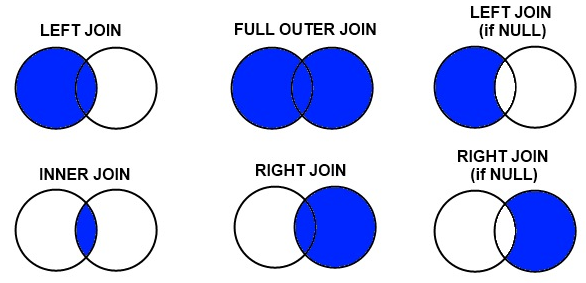

참조 : https://ahnty0122.tistory.com/69

이 순서는 이렇게 따름
1. 딕셔너리의 형태를 가진 문자열 데이터를 딕셔너리로 변환해야함.
2. crew data에서 감독 추출
3. cast data에서 배우 추출
4. genres data에서 장르 추출
5. keywords data에서 키워드 추출

In [71]:
#movieData의 id와 title, creditData의 movie_id, title 두개가 맞는 것을 이너조인(교집합)한다. 
MergedData = movieData.merge(creditData, left_on=['id', 'title'], right_on=['movie_id', 'title'], how='inner')
MergedData.head(3)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  ...  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   

                                    spoken_languages    status  \
0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1           [{"iso_639_1": "en", "name": "English"}]  Released   
2  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                      title vote_average vote_count        WR  \
0                                    Avatar          7.2      11800  7.050669   
1  Pirates of the Caribbean: At World's End          6.9       4500  6.665696   
2                                   Spectre          6.3       4466  6.239396   

  movie_id                                               cast  \
0    19995  [{"cast_id": 242, "character": "Jake Sully", "...   
1      285  [{"cast_id": 4, "character": "Captain Jack Spa...   
2   206647  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  

[3 rows x 24 columns]

### 3-1-1. 각 분야별 데이터를 string에서 dict로 변환하기


In [74]:
from ast import literal_eval

categories = ['cast', 'crew', 'genres', 'keywords']

for category in categories:
    MergedData[category] = MergedData[category].apply(literal_eval)

MergedData[categories].head()


cast  \
0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
3  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
4  [{'cast_id': 5, 'character': 'John Carter', 'c...   

                                                crew  \
0  [{'credit_id': '52fe48009251416c750aca23', 'de...   
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...   
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...   
3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...   
4  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...   

                                              genres  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                            keywords  
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...  
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...  
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...  
3  [{'id': 849, 'name': 'dc comics'}, {'id': 853,...  
4  [{'id': 818, 'name': 'based on novel'}, {'id':...

### 3-1-2. 감독 추출
- Why? Director 컬럼 추가해야하니까!

In [75]:
def GetDirectorInCrew(crew):
    director = ''
    for data in crew:
        if data.get('job') == 'Director':
            director = data.get('name')
            break
        
    return director

In [77]:
MergedData['director'] = MergedData['crew'].apply(GetDirectorInCrew)
MergedData.head()

budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   
3  [{'id': 849, 'name': 'dc comics'}, {'id': 853,...                en   
4  [{'id': 818, 'name': 'based on novel'}, {'id':...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  ...    status  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...  Released   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...  Released   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...  Released   
3  [{"name": "Legendary Pictures", "id": 923}, {"...  ...  Released   
4        [{"name": "Walt Disney Pictures", "id": 2}]  ...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average vote_count  \
0                                    Avatar           7.2      11800   
1  Pirates of the Caribbean: At World's End           6.9       4500   
2                                   Spectre           6.3       4466   
3                     The Dark Knight Rises           7.6       9106   
4                               John Carter           6.1       2124   

         WR movie_id                                               cast  \
0  7.050669    19995  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  6.665696      285  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  6.239396   206647  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
3  7.346721    49026  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
4  6.096368    49529  [{'cast_id': 5, 'character': 'John Carter', 'c...   

                                                crew           director  
0  [{'credit_id': '52fe48009251416c750aca23', 'de...      James Cameron  
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...     Gore Verbinski  
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...         Sam Mendes  
3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...  Christopher Nolan  
4  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...     Andrew Stanton  

[5 rows x 25 columns]

### 3-1-3. 배우 추출
- Why? actor 컬럼 추가할거니까요~

In [81]:
def GetActorsInCast(cast):
    actors = []
    if isinstance(cast, list):
        actors = [name['name'] for name in cast]
    return actors

In [82]:
MergedData['actors'] = MergedData['cast'].apply(GetActorsInCast)
MergedData.head()

budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   
3  [{'id': 849, 'name': 'dc comics'}, {'id': 853,...                en   
4  [{'id': 818, 'name': 'based on novel'}, {'id':...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  ...  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...  ...   
4        [{"name": "Walt Disney Pictures", "id": 2}]  ...   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   
2                                   Spectre           6.3        4466   
3                     The Dark Knight Rises           7.6        9106   
4                               John Carter           6.1        2124   

         WR movie_id                                               cast  \
0  7.050669    19995  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  6.665696      285  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  6.239396   206647  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
3  7.346721    49026  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
4  6.096368    49529  [{'cast_id': 5, 'character': 'John Carter', 'c...   

                                                crew           director  \
0  [{'credit_id': '52fe48009251416c750aca23', 'de...      James Cameron   
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...     Gore Verbinski   
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...         Sam Mendes   
3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...  Christopher Nolan   
4  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...     Andrew Stanton   

                                              actors  
0  [Sam Worthington, Zoe Sald

### 3-1-3. 장르 추출
- Why? genresName 컬럼 추가할거니까요~

In [85]:
def GetGenresInGenres(genres):
    genresName = []
    if isinstance(genres, list):
        genresName = [name['name'] for name in genres]

    return genresName

In [116]:
MergedData['genresNames'] = MergedData['genres'].apply(GetGenresInGenres)
MergedData.head()

budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   
3  [{'id': 849, 'name': 'dc comics'}, {'id': 853,...                en   
4  [{'id': 818, 'name': 'based on novel'}, {'id':...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  ... movie_id  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...    19995   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...      285   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   206647   
3  [{"name": "Legendary Pictures", "id": 923}, {"...  ...    49026   
4        [{"name": "Walt Disney Pictures", "id": 2}]  ...    49529   

                                                cast  \
0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
3  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
4  [{'cast_id': 5, 'character': 'John Carter', 'c...   

                                                crew          director  \
0  [{'credit_id': '52fe48009251416c750aca23', 'de...      jamescameron   
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...     goreverbinski   
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...         sammendes   
3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...  christophernolan   
4  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...     andrewstanton   

                                              actors  \
0  [samworthington, zoesaldana, sigourneyweaver, ...   
1  [johnnydepp, orlandobloom, keiraknightley, ste...   
2  [danielcraig, christophwaltz, léaseydoux, ralp...   
3  [christianbale, michaelcaine, garyoldman, anne...   
4  [taylorkitsch, lynncollins, samanthamorton, wi...   

                                      genresName  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                                       keyword_names  \
0  [culture clash, future, space war, space colon...   
1  [ocean, drug abuse, exotic island, east india ...   
2  [spy, based on novel, secret agent, sequel, mi...   
3  [dc comics, crime fighter, terr

### 3-1-4. 키워드 추출
- Why? keywordName 컬럼 추가할거니까요~

In [88]:
def get_keywords(keywords):
    keywordName = []
    if isinstance(keywords, list):
        keywordName = [name['name'] for name in keywords]
        
    return keywordName

In [95]:
MergedData['keywordNames'] = MergedData['keywords'].apply(get_keywords)
MergedData.head(3)

budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  ...        WR movie_id  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...  7.050669    19995   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...  6.665696      285   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...  6.239396   206647   

                                                cast  \
0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   

                                                crew        director  \
0  [{'credit_id': '52fe48009251416c750aca23', 'de...   James Cameron   
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...  Gore Verbinski   
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...      Sam Mendes   

                                              actors  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weave...   
1  [Johnny Depp, Orlando Bloom, Keira Knightley, ...   
2  [Daniel Craig, Christoph Waltz, Léa Seydoux, R...   

                                      genresName  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   

                                       keyword_names  \
0  [culture clash, future, space war, space colon...   
1  [ocean, drug abuse, exotic island, east india ...   
2  [spy, based on novel, secret agent, sequel, mi...   

                                     genresNames  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   

                                        keywordNames  
0  [culture clash, future, space war, space colon...  
1  [ocean, drug abuse, exotic island, east india ...  
2  [spy, based on novel, secret agent, sequel, mi...  

[3 rows x 30 columns]

### 3-1-5. 새로 생성한 값들끼리, 데이터셋을 생성

In [97]:
FilterdDataSet = ['title', 'director', 'actors', 'genresNames', 'keywordNames']
MergedData[FilterdDataSet].head(5)

title           director  \
0                                    Avatar      James Cameron   
1  Pirates of the Caribbean: At World's End     Gore Verbinski   
2                                   Spectre         Sam Mendes   
3                     The Dark Knight Rises  Christopher Nolan   
4                               John Carter     Andrew Stanton   

                                              actors  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weave...   
1  [Johnny Depp, Orlando Bloom, Keira Knightley, ...   
2  [Daniel Craig, Christoph Waltz, Léa Seydoux, R...   
3  [Christian Bale, Michael Caine, Gary Oldman, A...   
4  [Taylor Kitsch, Lynn Collins, Samantha Morton,...   

                                     genresNames  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                                        keywordNames  
0  [culture clash, future, space war, space colon...  
1  [ocean, drug abuse, exotic island, east india ...  
2  [spy, based on novel, secret agent, sequel, mi...  
3  [dc comics, crime fighter, terrorist, secret i...  
4  [based on novel, mars, medallion, space travel...

In [102]:
def SetCleanUpData(data):
    #공백 제거, 소문자 치환    
    if isinstance(data, list):
        return [str.lower(val.replace(" ", "")) for val in data]
    else:

        if isinstance(data, str):
            return str.lower(data.replace(" ", ""))
        else:
            return ''

In [103]:
CleanupTarget = ['director', 'actors', 'genresNames', 'keywordNames']

for column in CleanupTarget:
    MergedData[column] = MergedData[column].apply(SetCleanUpData)
    
MergedData[CleanupTarget].head(5)

director                                             actors  \
0      jamescameron  [samworthington, zoesaldana, sigourneyweaver, ...   
1     goreverbinski  [johnnydepp, orlandobloom, keiraknightley, ste...   
2         sammendes  [danielcraig, christophwaltz, léaseydoux, ralp...   
3  christophernolan  [christianbale, michaelcaine, garyoldman, anne...   
4     andrewstanton  [taylorkitsch, lynncollins, samanthamorton, wi...   

                                    genresNames  \
0  [action, adventure, fantasy, sciencefiction]   
1                  [adventure, fantasy, action]   
2                    [action, adventure, crime]   
3              [action, crime, drama, thriller]   
4           [action, adventure, sciencefiction]   

                                        keywordNames  
0  [cultureclash, future, spacewar, spacecolony, ...  
1  [ocean, drugabuse, exoticisland, eastindiatrad...  
2  [spy, basedonnovel, secretagent, sequel, mi6, ...  
3  [dccomics, crimefighter, terrorist, secretiden...  
4  [basedonnovel, mars, medallion, spacetravel, p...

### 3-1-6. data soup 만들기

**"Soup"**는 영화나 상품과 관련된 여러 정보(줄거리, 장르, 감독 등)를 하나의 문자열로 연결한 것

예를 들어, 영화의 여러 특성을 합쳐 다음과 같은 "data soup"을 생성할 수 있습니다:

"Action Adventure James Cameron Leonardo DiCaprio Titanic sinking romance"

1. 텍스트 기반 추천 시스템 개선

    - 줄거리(overview)만으로는 영화의 모든 특성을 반영하기 어려워요.

    - 장르, 감독, 출연진 등 다양한 정보를 합치면, 더 나은 유사도 계산이 가능하겠죠?.

2. 콘텐츠 기반 필터링(Content-Based Filtering) 강화

    - 사용자가 특정 감독이나 배우를 좋아할 경우 해당 특성이 포함된 영화들을 쉽게 추천할 수 있죠.

    - 예를 들어, 한 사용자가 **제임스 카메론(James Cameron)**의 영화를 선호할 경우, 감독 정보가 포함된 soup을 통해 더 정확한 추천이 가능해요.

3. TF-IDF 벡터화 및 코사인 유사도 활용

    - Data Soup을 만들어 전체 영화의 텍스트를 TF-IDF 벡터로 변환하고, 코사인 유사도를 계산할 수 있습니다. 이 작업은 영화 간의 다차원적 유사성을 반영하는 데 유리해요.

In [117]:
def SetDataSoup(data):
    #Data soup는 기본적으로 데이터를 이어붙이는 겁니다. 한줄로!
    result = f"{data['director']}    {' '.join(data['actors'])}    {' '.join(data['genresNames'])}    {' '.join(data['keywordNames'])}"
    return result
SetDataSoup(MergedData.iloc[0,:])

'jamescameron    samworthington zoesaldana sigourneyweaver stephenlang michellerodriguez giovanniribisi joeldavidmoore cchpounder wesstudi lazalonso dileeprao mattgerald seananthonymoran jasonwhyte scottlawrence kellykilgour jamespatrickpitt seanpatrickmurphy peterdillon kevindorman kelsonhenderson davidvanhorn jacobtomuri michaelblain-rozgay joncurry lukehawker woodyschultz petermensah soniayee jahnelcurfman ilramchoi kylawarren lisaroumain debrawilson chrismala taylorkibby jodielandau julielamm cullenb.madden josephbradymadden frankietorres austinwilson sarawilson tamicawashington-miller lucybriant nathanmeister gerryblair matthewchamberlain paulyates wraywilson jamesgaylyn melvinlenoclarkiii carvonfutrell brandonjelkes micahmoch hanniyahmuhammad christophernolen christaoliver aprilmariethomas bravitaa.threatt colinbleasdale mikebodnar mattclayton nicoledionne jamieharrison allanhenry anthonyingruber ashleyjeffery deanknowsley josephmika-hunt terrynotary kaipantano loganpithyou stuar

title을 기준으로 Soup에는 director, actors, keywordNames, genresNames가 전부 합쳐져 있음.

In [111]:
MergedData['Soup'] = MergedData.apply(SetDataSoup, axis=1)

NewFilters = ['title', 'director', 'actors', 'keywordNames', 'genresNames', 'Soup']
MergedData[NewFilters].head(5)

title          director  \
0                                    Avatar      jamescameron   
1  Pirates of the Caribbean: At World's End     goreverbinski   
2                                   Spectre         sammendes   
3                     The Dark Knight Rises  christophernolan   
4                               John Carter     andrewstanton   

                                              actors  \
0  [samworthington, zoesaldana, sigourneyweaver, ...   
1  [johnnydepp, orlandobloom, keiraknightley, ste...   
2  [danielcraig, christophwaltz, léaseydoux, ralp...   
3  [christianbale, michaelcaine, garyoldman, anne...   
4  [taylorkitsch, lynncollins, samanthamorton, wi...   

                                        keywordNames  \
0  [cultureclash, future, spacewar, spacecolony, ...   
1  [ocean, drugabuse, exoticisland, eastindiatrad...   
2  [spy, basedonnovel, secretagent, sequel, mi6, ...   
3  [dccomics, crimefighter, terrorist, secretiden...   
4  [basedonnovel, mars, medallion, spacetravel, p...   

                                    genresNames  \
0  [action, adventure, fantasy, sciencefiction]   
1                  [adventure, fantasy, action]   
2                    [action, adventure, crime]   
3              [action, crime, drama, thriller]   
4           [action, adventure, sciencefiction]   

                                                Soup  
0  jamescameron    samworthington zoesaldana sigo...  
1  goreverbinski    johnnydepp orlandobloom keira...  
2  sammendes    danielcraig christophwaltz léasey...  
3  christophernolan    christianbale michaelcaine...  
4  andrewstanton    taylorkitsch lynncollins sama...

### 3-1-7. DataSoup에 CountVectorizer 를 떄리면... 결과가 나옵니다. 

In [112]:
#벡터라이저 객체 생성
counterVector = CountVectorizer(stop_words='english')
#NaN 처리
MergedData['Soup'] = MergedData['Soup'].fillna('')

#벡터라이저 학습
counterVectorShape = counterVector.fit_transform(MergedData['Soup'])

print("CounterVectorizer 맵 =", counterVectorShape.shape)

words = counterVector.get_feature_names_out() #벡터 목록 가져오기
counts = counterVectorShape.sum(axis=0).reshape(-1,1).tolist()

WordAndCount = dict(
    sorted(
        zip(words,counts), #단어와 빈도를 묶음
        key=lambda x : x[1], # 두번째 값으로 정렬
        reverse=True # 내림차순
        )
    )
print(json.dumps(WordAndCount, indent=4))

CounterVectorizer 맵 = (4803, 66904)
{
    "drama": [
        2308
    ],
    "comedy": [
        1747
    ],
    "thriller": [
        1277
    ],
    "action": [
        1157
    ],
    "romance": [
        917
    ],
    "adventure": [
        808
    ],
    "crime": [
        716
    ],
    "family": [
        591
    ],
    "sciencefiction": [
        540
    ],
    "horror": [
        530
    ],
    "fantasy": [
        443
    ],
    "mystery": [
        355
    ],
    "womandirector": [
        324
    ],
    "independentfilm": [
        318
    ],
    "duringcreditsstinger": [
        307
    ],
    "animation": [
        261
    ],
    "music": [
        231
    ],
    "history": [
        206
    ],
    "basedonnovel": [
        197
    ],
    "murder": [
        190
    ],
    "war": [
        189
    ],
    "aftercreditsstinger": [
        170
    ],
    "violence": [
        150
    ],
    "jean": [
        145
    ],
    "dystopia": [
        139
    ],
    "sport": [
   

### 3-1-8. 테스트 해보기

In [114]:
CosineSimilarity = GetCosineSimilarity(counterVectorShape)
GetMovieRecommendation('Spider-Man 2', CosineSimilarity)

[5, 159, 37, 215, 1598, 7, 165, 26, 38, 79]


title        WR
7                    Avengers: Age of Ultron  7.041968
26                Captain America: Civil War  6.895935
159                               Spider-Man  6.616810
79                                Iron Man 2  6.492535
38                  The Amazing Spider-Man 2  6.375403
1598                         Drag Me to Hell  6.129314
5                               Spider-Man 3  5.965250
37                Oz: The Great and Powerful  5.834299
165                                     Hulk  5.731965
215   Fantastic 4: Rise of the Silver Surfer  5.687412